# Welcome to our Severity Index for Hurricanes and Tropical Storms!
This tutorial will go over what ECMWF model data we collected and how we constructed our Severity Index (damage algorithm), for which areas were affected the most during major tropical events.


## Data collected and what model runs were chosen:

- Hurricane Helene on September 27th, 2024: 00 UTC Forecast hour 6 (and full model run 0-240)
- Hurricane Debby on August 5th, 2024: with the full 0-240 run
- Tropical Storm Arlene on June 2nd, 2023: with the full 0-240 run

## Model runs used:
- ECMWF using FastHerbie
- Note: This only selects forecast hour 6, when downloading an entire model run, see comment below labelled (# downloading the entire model)

The original case we were testing on was the September 27th run, which is why we used initially a single run, and later on a full run.

In [19]:
from herbie import Herbie, FastHerbie
import pandas as pd, numpy as np
import xarray as xr
import dask

runtime = pd.Timestamp("2024-09-27", tz="utc").replace(tzinfo=None).floor('24h')
H = Herbie(runtime, model="ifs", product="oper", fxx=6, save_dir='.', overwrite=True)

# downloading the entire model
#H = FastHerbie([runtime], model="ifs", product="oper", fxx=np.arange(0,246,6).tolist(), save_dir='.', overwrite=True)


✅ Found ┊ model=ifs ┊ product=oper ┊ 2024-Sep-27 00:00 UTC F06 ┊ GRIB2 @ aws ┊ IDX @ aws


### Herbie (single run) and Fast Herbie (full run) are both available. We input the dates we wanted to use and chose forecast hours. 
- 'ifs' stands for 'integrated forecast system' or in this case ECMWF.
- DATES should be inputted as YYYY-MM-DD, ex. 2023-09-02

In [2]:
df = H.inventory()

param_column = df['param']
print(df['param'].tolist())

['100v', 'v', 'u', 't', 'cape', 'gh', '2t', 'swvl2', 'u', 'v', 't', 'gh', 'st', 'swvl1', 'gh', '100u', 'r', 'r', 'r', 'r', 'gh', 'r', 'ssrd', 'tp', 'gh', 'swvl3', 'r', 't', 'v', 'u', '2d', 'u', 'v', 't', 't', 'v', 'u', 'v', 'u', 'skt', 'r', 'v', 'u', 'gh', 't', 'gh', 'u', 'v', 'gh', 'gh', 'stl2', 'msl', 'stl3', 't', 'sp', 'u', 'v', 't', '10u', 'u', 'v', 'v', 'u', 'v', 'u', 't', 'u', 'v', 'gh', 'r', 'r', 't', '10v', 'gh', 'swvl4', 't', 'gh', 'r', 'w', 'ssr', 't', 'w', 'stl4', 'r', 'w', 'gh', 'tcwv', 't', 'r', 'q', 'q', 'w', 'q', 'r', 'q', 'q', 'lsm', 'w', 'w', 'w', 'w', 'q', 'q', 'q', 'w', 'strd', 'q', 'w', 'q', 'str', 'q', 'w', 'q', 'w', 'q', 'w', 'd', 'vo', 'd', 'vo', 'd', 'd', 'vo', 'vo', 'd', 'asn', 'd', 'vo', 'd', 'd', 'ro', 'vo', 'vo', 'vo', 'd', 'ttr', 'd', 'd', 'd', 'vo', 'vo', 'd', 'vo', 'vo', 'vo']


- This will display the different variables available during a speciic model run.
- Be careful to check the variables between model runs, they are all not standardized. We noticed differences between ECMWF and GFS model runs, and even among multiple ECMWF model runs.
- For this project, seeing all of the variables available for the model runs was helpful in allowing us to pick which we wanted to go into our index.
- This website was helpful for ECMWF documentation: https://codes.ecmwf.int/grib/param-db/

### Next, we defined which variables we wanted to use to work towards our end goal of a **severity index**:
- **Wind Speed:** Strong winds can cause significant damage, including destruction of buildings, fallen trees, and power outages. By including wind speed in the index, we can identify areas that might be most affected by wind-related impacts.
- **Precipitation Rate:** Intense rainfall can lead to flash flooding and strain drainage systems. Areas with higher precipitation rates are often at greater risk for flooding, which is a major concern during tropical events.
- **Vorticity:** Vorticity measures the spin of the air in the storm, helping us understand the storm’s organization and intensity. Higher vorticity often indicates a more organized storm, which is linked to stronger winds and potentially more damage.
- **Surface Pressure:** Low surface pressure is a key feature of tropical storms, and when pressure drops, it typically means the storm is strengthening. Monitoring surface pressure helps us track how the storm is evolving over time.
- These four variables together provide a more complete picture of the storm’s severity, helping us understand both the immediate and longer-term risks as the storm progresses.

Below is a sample of how we picked specific variables to pull out of the large dataset, we took out more than just the four above to show the availability of variables.
Note, we used tp (total precipitation) as the foundation for our precipitation rate variable. This was NOT in most of the model runs we analyzed, and is a calculated value. The calculation is shown within the normalization function we developed further below.

In [3]:
ss2 = "((gh|t|u|v|vo|q):(1000|500)|tp|sp|strd|lsp)"
H.inventory(ss2)

/usr/local/anaconda3/envs/custom_envs/meteo473_sp25/lib/python3.13/site-packages/herbie/core.py:812: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  logic = df.search_this.str.contains(search)


,grib_message,start_byte,end_byte,range,reference_time,valid_time,step,param,levelist,levtype,number,domain,expver,class,type,stream,search_this
5,6,4313742,4857734,4313742-4857734,2024-09-27,2024-09-27 06:00:00,0 days 06:00:00,gh,1000,pl,NaN,g,0001,od,fc,oper,:gh:1000:pl:g:0001:od:fc:oper
11,12,8003468,8387069,8003468-8387069,2024-09-27,2024-09-27 06:00:00,0 days 06:00:00,gh,500,pl,NaN,g,0001,od,fc,oper,:gh:500:pl:g:0001:od:fc:oper
23,24,15170136,15863084,15170136-15863084,2024-09-27,2024-09-27 06:00:00,0 days 06:00:00,tp,NaN,sfc,NaN,g,0001,od,fc,oper,:tp:sfc:g:0001:od:fc:oper
27,28,17151421,17759527,17151421-17759527,2024-09-27,2024-09-27 06:00:00,0 days 06:00:00,t,500,pl,NaN,g,0001,od,fc,oper,:t:500:pl:g:0001:od:fc:oper
33,34,21236896,21837933,21236896-21837933,2024-09-27,2024-09-27 06:00:00,0 days 06:00:00,t,1000,pl,NaN,g,0001,od,fc,oper,:t:1000:pl:g:0001:od:fc:oper
54,55,33871406,34408615,33871406-34408615,2024-09-27,2024-09-27 06:00:00,0 days 06:00:00,sp,NaN,sfc,NaN,g,0001,od,fc,oper,:sp:sfc:g:0001:od:fc:oper
61,62,38726909,39455272,38726909-39455272,2024-09-27,2024-09-27 06:00:00,0 days 06:00:00,v,500,pl,NaN,g,0001,od,fc,oper,:v:500:pl:g:0001:od:fc:oper
62,63,39455272,40160259,39455272-40160259,2024-09-27,2024-09-27 06:00:00,0 days 06:00:00,u,500,pl,NaN,g,0001,od,fc,oper,:u:500:pl:g:0001:od:fc:oper
66,67,42270990,43104641,42270990-43104641,2024-09-27,2024-09-27 06:00:00,0 days 06:00:00,u,1000,pl,NaN,g,0001,od,fc,oper,:u:1000:pl:g:0001:od:fc:oper
67,68,43104641,43936163,43104641-43936163,2024-09-27,2024-09-27 06:00:00,0 days 06:00:00,v,1000,pl,NaN,g,0001,od,fc,oper,:v:1000:pl:g:0001:od:fc:oper


## Downloading our dataset:
1.  Give the inventory a name and download it
2.  Open the dataset back up under another variable
3.  Then convert it to a netcdf under a filepath, for easy use later on.

In [4]:
fp = H.download(ss2)
fp # downloading our chosen ecwmf model run particulary a forecast hour during Hurricane Helene

/usr/local/anaconda3/envs/custom_envs/meteo473_sp25/lib/python3.13/site-packages/herbie/core.py:812: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  logic = df.search_this.str.contains(search)


PosixPath('ifs/20240927/subset_f7b27cfd__20240927000000-6h-oper-fc.grib2')

When downloading your selected data set, it should match the directory in which we contained the rest of our downloads, Jupyter notebooks, and (eventually) downloaded displays.
In this case, this directory was contained within a larger folder, containing only the files we used in the Final Project.

In [5]:
ds = xr.open_dataset(fp)
ds.to_netcdf('/home/lda5159/Meteo473FinalProject/meteo473gfs9272024.nc')
ds

Ignoring index file 'ifs/20240927/subset_f7b27cfd__20240927000000-6h-oper-fc.grib2.5b7b6.idx' older than GRIB file


<xarray.Dataset> Size: 62MB
Dimensions:        (isobaricInhPa: 2, latitude: 721, longitude: 1440)
Coordinates:
    time           datetime64[ns] 8B ...
    step           timedelta64[ns] 8B ...
  * isobaricInhPa  (isobaricInhPa) float64 16B 1e+03 500.0
  * latitude       (latitude) float64 6kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude      (longitude) float64 12kB -180.0 -179.8 -179.5 ... 179.5 179.8
    valid_time     datetime64[ns] 8B ...
    surface        float64 8B ...
Data variables:
    gh             (isobaricInhPa, latitude, longitude) float32 8MB ...
    tp             (latitude, longitude) float32 4MB ...
    t              (isobaricInhPa, latitude, longitude) float32 8MB ...
    sp             (latitude, longitude) float32 4MB ...
    v              (isobaricInhPa, latitude, longitude) float32 8MB ...
    u              (isobaricInhPa, latitude, longitude) float32 8MB ...
    q              (isobaricInhPa, latitude, longitude) float32 8MB ...
    strd           (latitude, longitude) float32 4MB ...
    vo             (isobaricInhPa, latitude, longitude) float32 8MB ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-04-29T09:48 GRIB to CDM+CF via cfgrib-0.9.1...

In order to be able to download the data correctly for the full model run, there are a few extra steps (code) we needed to implement in order for it to work aside from the singular model run method. After implementing this line, we were able to download the data the same way below as we did for the singular run. (see downloading step above)

In [ ]:
ds = xr.open_mfdataset(fp, combine='nested', concat_dim='valid_time')

## Test Display For your Downloaded Data
- After downloading in our data, select the variables in which we would like to plot, in our initial ideas we selected vorticity, geopotential height, temperature, and more.
- Note, some variables may have multiple pressure levels in which there is recorded data, select the appropriate levels.
- Note, some variables in ECWMF model runs are not necessarily in the units we wanted, we had to convert (like we did for Temperature).
- Note, we selected the longitude and latitude range in order to "zoom in" or "zoom out" to look at specific areas in CONUS. This is where we selected the range in which we wanted our selected to plot, mostly the southeast and Gulf of Mexico. These numbers can be changed in order to show different regions, however since this is being used for Tropical Events, we decided this was the best representative region for the events we chose.

In [6]:
import pandas as pd, numpy as np
import xarray as xr
import dask
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import ListedColormap

ogds = xr.open_dataset('meteo473gfs9272024.nc') # You can also create your own run and name it a .nc file

ds = ogds.sel(longitude = slice(-97, -70), latitude = slice(35, 26))
lat = ds.latitude.values
lon = ds.longitude.values
vo = ds['vo'].values
gh = ds['gh'].sel(isobaricInhPa = 500).values
t = ds['t'].sel(isobaricInhPa = 1000).values
tF = ((t-273) * (9/5)) + 32
tp = ds['tp'].values
sp = ds['sp'].values
uNew = ds['u'].sel(isobaricInhPa = 1000).values
vNew = ds['v'].sel(isobaricInhPa = 1000).values

## Creating the Test Plot
- The development of the basemap was consistent among all plots, with the same boundaries, and map projection.
- Contourf plots represented the majority of our plots, the color contrast allowed us to display data well.

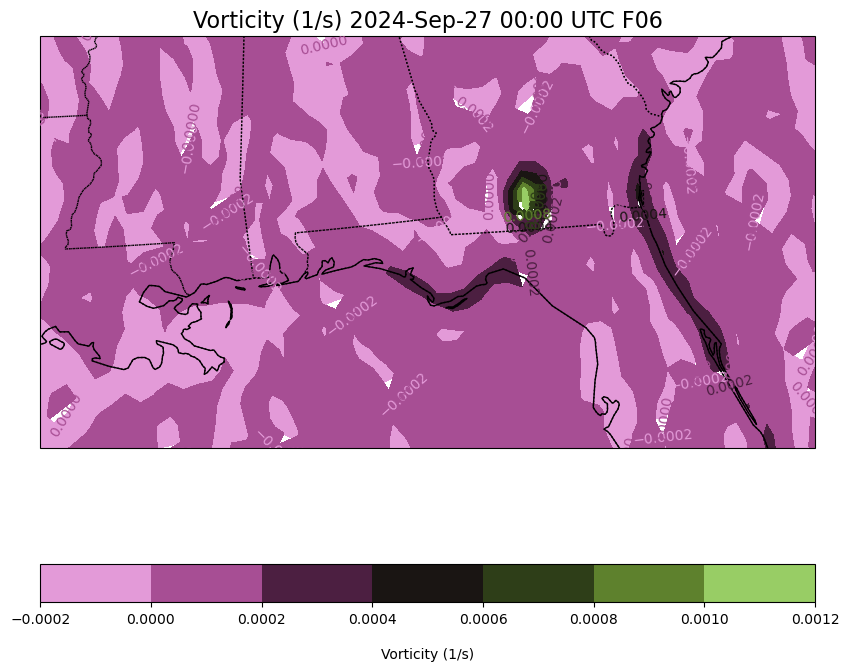

In [7]:
dataproj = ccrs.PlateCarree()

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection=ccrs.LambertConformal())
ax.set_extent([-92,-79,33,28], ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE.with_scale('50m'))
ax.add_feature(cfeature.STATES.with_scale('50m'), linestyle=':')
ax.add_feature(cfeature.BORDERS.with_scale('50m'))

cs = ax.contourf(lon, lat, vo[0,:,:], cmap = 'vanimo', transform=dataproj)
plt.clabel(cs)

cbar = plt.colorbar(cs, ax=ax, orientation='horizontal')
cbar.set_label('Vorticity (1/s)', rotation=0, labelpad=15)

ax.set_title('Vorticity (1/s) 2024-Sep-27 00:00 UTC F06', fontsize=16)

plt.show()


- #### This will be able to successfully plot a map of vorticity for Hurricane Helene at 00 UTC.
- #### The longitude and latittude is sliced in order to specifically focus on the southeast region of the United States.
- #### Using basic map features with the coastline and state borders are also seen above in the code block.
- #### We also have our values selected 'vo' is vorticity, 'gh' is geopotential height, 't' is temperature, 'tp' is total precipitation, 'sp' is surface pressure, and 'u' and 'v' are components of the wind.

# **Defining an index**
+ ### Once again, using vorticity as our example case:
1.  **Normalizing your variable:**

   - We determined the four variables that would contribute the most to an index in relation to tropical events would be Vorticity, Pressure, Precipitation rate (calculated value), and Wind.
   - Variable, is the selected downloaded variable we got above, and min_val and max_val are defined values in which we developed to represent a range of severity seen for each individual variable for tropical events.
   - The calculation for precipitation was converted from meters (again be careful of units!) to then in inches, and divided by the number of hours between, in this case 6 hours.
   - We repeated this process for each component that went into our index, that would be able to take in full lists (here our data set would be plugged in for the space that contains lst) and would return our normalized variable.

In [4]:
def normalize(var, min_val, max_val): 
    return (var - min_val) / (max_val - min_val)

def find_vorticity(lst):
    vo = lst['vo'].sel(isobaricInhPa=500) 
    vorticity_norm = normalize(vo, -0.00001, 0.003)
    return vorticity_norm

# finding the pressure normalization 
def find_pressure(lst):
    sp = lst['sp'].values / 100
    pressure_norm = normalize(sp, 980, 1020)
    return pressure_norm

# finding the precipitation rate normalization
def find_prate(lst):
    tp = lst['tp'].values
    approximatedprate = (tp * 39.37) / 6  # conversion to inches per hour (originally was in meters)
    prate_norm = normalize(approximatedprate, 0.1, 1.0)
    return prate_norm

# find wind normalization
def find_wind(lst):
    uNew = lst['u'].sel(isobaricInhPa=1000).values
    vNew = lst['v'].sel(isobaricInhPa=1000).values
    totalwind = ((uNew ** 2 + vNew ** 2) ** 0.5) * 2 # conversion to knots for easier plotting
    totalwind_norm = normalize(totalwind, 0, 140)
    return totalwind_norm
    

## But why did we choose to normalize these variables?
- Due to the fact different tropical events have different strengths, normalization was necessary to help define some of these differences when plotting and describing our index.
- This "standardization" of the values allowed us to navigate relative "strength" towards increasing severity as displayed on our index.
- For example, standardization of wind, based off of the scale of no wind, to Category 5+ Hurricane strength, allowed us to take a specific data point of wind, compare it to our range
- Normalization of all of these variables allowed us to combine them all together, as the normalization allows fo combinations of different units and scales, which then went into our index formula.


**Define your threat formula** 
- By using the variables defined above, we built a **Severity Index** in which the most contributing components were **Wind** and **Precipitation Rate**, based off the fact the most damage in tropical events is usually attributed to Wind/Rain (flooding associated with rain). The smaller components of the index were built by the **Vorticity** and **Pressure** variables, as they also can help evaluate strength in tropical events, with stronger storms showing lower pressures and potentially higher values for vorticity. The second two were not considered as "defining" towards the severity of a tropical event and thus weighted less in the index.

### Weighting the variables
In our index equation, wind speed and precipitation rate are the most heavily weighted factors due to their direct and significant impact on weather conditions, particularly in terms of storm intensity and severity. Wind speed is a critical indicator of atmospheric dynamics, influencing the strength and movement of storms. High wind speeds are often associated with severe weather phenomena like thunderstorms, hurricanes, and tornadoes, making it a key determinant in our index. Precipitation rate, on the other hand, directly reflects the amount and intensity of rainfall, which can have immediate effects on flooding, visibility, and overall safety conditions. This is why wind was the highest weighted variable in our index, followed by precipitation rate.

While wind speed and precipitation rate are prioritized, vorticity and pressure are also important components in our model, though they carry slightly less weight. Vorticity helps us understand rotational motion in the atmosphere, which is essential for identifying the formation of cyclones or other rotating storm systems. Pressure is a fundamental atmospheric variable that can indicate large-scale weather systems like high- or low-pressure systems, which influence weather patterns. Though slightly less weighted, both vorticity and pressure provide essential context, helping to refine our predictions and providing a more complete picture of atmospheric behavior.

Overall, this weighting strategy is justified by the fact that wind and precipitation have the most direct and immediate effects on weather-related impacts, while vorticity and pressure help to capture broader atmospheric trends that enhance the overall predictive accuracy of the index.

In [ ]:
severity_index = abs((0.5 * totalwind_norm) + (0.3 * prate_norm) + (0.15 * vorticity_norm) + (0.05 * pressure_norm))
severity_index = severity_index * 10

After developing the formula for our index, we then developed another formula that combined all of the previously defined functions above. It has the capability of taking a full model run, and outputting the severity index values for that run, as well as all of the normalized variables for that specific run. We decided to then multiply the entire index by 10, just to make the numbers make a little bit more sense on our defined index 0-5.

In [ ]:
# threat function
def find_threat(lst):
     # pulling in the previously defined functions and use them on the inputted list
    pressure_norm = find_pressure(lst)
    vorticity_norm = find_vorticity(lst)
    totalwind_norm = find_wind(lst)
    prate_norm = find_prate(lst)

    # threat formula 
    severity_index = abs((0.5 * totalwind_norm) + (0.3 * prate_norm) + (0.15 * vorticity_norm) + (0.05 * pressure_norm))
    # weighted severity index, we decided to have it mostly based on total wind and precipitation, with small components of the vorticity and pressure for some more depth
    severity_index = severity_index * 10
    # multitplied our index by ten to make the values a little more " realistic " to have a range 1-5 instead of decimals
    return severity_index

### For example... We evenly gauged different variables and their values so that they are scaled out on a 0-5 scale

![My Image](ms3-1.PNG)

![ms3-1](ms3-2.PNG)

## **Running your requested event for a model run for the first six forecast hours:** 

After development of all functions for the specific index, and variables, we created a final function that bundled everything into one big "hidden" step. 
This combines:
- opening the dataset
- sorting by the valid time to ensure all time steps are in the right order
- finding all of the variables using predifed functions within this bigger function
- calculating the index
- all of the plotting steps required to create a panel of plots for all of the variables and index

Note, the selected example runs at the bottom when calling the function are the full downloaded models using the alternative fxx line listed all the way at the top during the download step. In order to get the requested first six forecast hours we had use the alternative download to ensure the Herbie downloads more than just 1 hour.

- This is important to include when wanting to download a full model run from 0 to 246.
- fxx is altered to compute the full run instead of just running it over a single forecast hour from before.

In [ ]:
# Each forecast run is 6 hours each with there being 6 different plots for every one of
# our variables. Define a file name for the full model run you want to use and open it.
def plot_forcasted_six_hours(file_name):
    ogds = xr.open_dataset(file_name)
    ogds = ogds.sortby('valid_time')
    
    #allowing for unit conversions
    ogds = convert_temperature_to_kelvin(ogds)

    # Looping through the first 6 forecast hours (36 total hours)
    for i in range(6):
        ds = ogds.isel(valid_time=i)
        ds1 = ds.sel(longitude=slice(-97, -79), latitude=slice(37, 22))
        lat = ds1.latitude.values
        lon = ds1.longitude.values
        
        severity_index_adjust = find_threat(ds1)
        pressure_norm = find_pressure(ds1)
        vorticity_norm = find_vorticity(ds1)
        totalwind_norm = find_wind(ds1)
        prate_norm = find_prate(ds1)
        
        valid_time_str = np.datetime_as_string(ds.valid_time.values, unit='h')
        dataproj = ccrs.PlateCarree()
        fig = plt.figure(figsize=(14, 14))
    
        # Subplot 1: Pressure
        ax = fig.add_subplot(231, projection=ccrs.LambertConformal())
        ax.set_extent([-95, -81, 36, 25], dataproj)
        ax.add_feature(cfeature.COASTLINE.with_scale('50m'))
        ax.add_feature(cfeature.STATES.with_scale('50m'), linestyle=':')
        ax.add_feature(cfeature.BORDERS.with_scale('50m'))
        cs = ax.contourf(lon, lat, 0.15 * pressure_norm, cmap='gist_earth', transform=dataproj, vmin = -0.4, vmax = 0.16) # standardized color bar for consistency
        cbar = plt.colorbar(cs, ax=ax, orientation='horizontal')
        cbar.set_label('Normalized Pressure Index', rotation=0, labelpad=15)
        ax.set_title(f'Normalized Pressure {valid_time_str} UTC', fontsize=14)
    
        # Subplot 2: Vorticity
        ax = fig.add_subplot(232, projection=ccrs.LambertConformal())
        ax.set_extent([-95, -81, 36, 25], dataproj)
        ax.add_feature(cfeature.COASTLINE.with_scale('50m'))
        ax.add_feature(cfeature.STATES.with_scale('50m'), linestyle=':')
        ax.add_feature(cfeature.BORDERS.with_scale('50m'))
        cs = ax.contourf(lon, lat, 0.05 * vorticity_norm, cmap='viridis', transform=dataproj, vmin = -0.008, vmax = 0.044) # standardized color bar for consistency
        cbar = plt.colorbar(cs, ax=ax, orientation='horizontal')
        cbar.set_label('Normalized Vorticity', rotation=0, labelpad=15)
        ax.set_title(f'Normalized Vorticity {valid_time_str} UTC', fontsize=14)
    
        # Subplot 3: Precipitation Rate
        ax = fig.add_subplot(233, projection=ccrs.LambertConformal())
        ax.set_extent([-95, -81, 36, 25], dataproj)
        ax.add_feature(cfeature.COASTLINE.with_scale('50m'))
        ax.add_feature(cfeature.STATES.with_scale('50m'), linestyle=':')
        ax.add_feature(cfeature.BORDERS.with_scale('50m'))
        cs = ax.contourf(lon, lat, 0.4 * prate_norm, cmap='Blues', transform=dataproj, vmin = -0.15, vmax = 1) # standardized color bar for consistency
        cbar = plt.colorbar(cs, ax=ax, orientation='horizontal')
        cbar.set_label('Normalized Precipitation Rate', rotation=0, labelpad=15)
        ax.set_title(f'Precip Rate {valid_time_str} UTC', fontsize=14)
    
        # Subplot 4: Wind
        ax = fig.add_subplot(234, projection=ccrs.LambertConformal())
        ax.set_extent([-95, -81, 36, 25], dataproj)
        ax.add_feature(cfeature.COASTLINE.with_scale('50m'))
        ax.add_feature(cfeature.STATES.with_scale('50m'), linestyle=':')
        ax.add_feature(cfeature.BORDERS.with_scale('50m'))
        cs = ax.contourf(lon, lat, 0.5 * totalwind_norm, cmap='BuPu', transform=dataproj, vmin = 0 , vmax = 0.175) # standardized color bar for consistency
        cbar = plt.colorbar(cs, ax=ax, orientation='horizontal')
        cbar.set_label('Total Wind Normalized Index', rotation=0, labelpad=15)
        ax.set_title(f'Total Wind {valid_time_str} UTC', fontsize=14)
    
        # Subplot 5: Severity Index
        ax = fig.add_subplot(236, projection=ccrs.LambertConformal())
        ax.set_extent([-95, -81, 36, 25], dataproj)
        ax.add_feature(cfeature.COASTLINE.with_scale('50m'))
        ax.add_feature(cfeature.STATES.with_scale('50m'), linestyle=':')
        ax.add_feature(cfeature.BORDERS.with_scale('50m'))
        mesh = ax.pcolormesh(lon, lat, severity_index_adjust, cmap='Blues',
                         transform=dataproj, shading='auto')
        mesh.set_clim(0, 5) # standardized color bar for consistency
        
        cbar = plt.colorbar(mesh, ax=ax, orientation='horizontal', shrink=0.7)
        cbar.set_label('Severity Index', rotation=0, labelpad=15)
        ax.set_title(f'Severity Index {valid_time_str} UTC', fontsize=14)
    
        plt.suptitle(f'Severity Components - Forecast Hour {i}', fontsize=18)
        plt.tight_layout()
        plt.show()
        plt.close()

# original test case 08/05/2024
plot_forcasted_six_hours('meteo473ecmwf08052024t2.nc')

# additional high end test case 09/27/2024
plot_forcasted_six_hours('meteo473ecmwf09272024t2.nc')

# additional low end test case 06/02/2023
plot_forcasted_six_hours('meteo473ecmwf06022023t2.nc')

### Everything from our graphs before is placed in a function for the full run so we did not have to copy and paste code multiple different times.
### Note: be careful when normalizing different values, we had to make sure to take representative ranges for the variables, ensuring we covered both the low and high end events

## Creating Plots for an Entire Model Run 0-240

In order to plot and subsequently download images for a full model run, we developed one more function that contained multiple for loops. These for loops were essential in looping through all of the data, with the first looping through all of the hours in groups of six, and the second grouping our output plots in groups of six to cut down on the absolute volume of plots produced. In this case file_name is the same as the previous (lst) which is the name of the file that you downloaded at the beginning. The last line underneath the function shows an example of using the defined function on an example of one of the data sets we used.

In [ ]:
# defining a function to do the entire model run plots 
def plot_index_over_240(file_name):
    ogds = xr.open_dataset(file_name)  # Load dataset
    ogds = ogds.sortby('valid_time')  # Sort by time

    proj = ccrs.LambertConformal()

    # Loop in batches of 6 forecast hours
    for batch_start in range(0, 246, 6):
        fig, axs = plt.subplots(
            nrows=2, ncols=3, figsize=(14, 12),  # smaller height
            subplot_kw={'projection': proj}
        )
        axs = axs.flatten()
        
        # batching plots into groups of six
        for idx in range(6):
            time_idx = batch_start + idx
            ds = ogds.isel(valid_time=time_idx)
            ds = ds.sel(longitude=slice(-97, -79), latitude=slice(37, 22))
            lat = ds.latitude.values
            lon = ds.longitude.values

            severity_index_adjust = find_threat(ds)

            valid_time_str = np.datetime_as_string(ds.valid_time.values, unit='h')

            ax = axs[idx]
            ax.set_extent([-95, -81, 36, 25], proj)
            ax.add_feature(cfeature.COASTLINE.with_scale('50m'))
            ax.add_feature(cfeature.STATES.with_scale('50m'), linestyle=':')
            ax.add_feature(cfeature.BORDERS.with_scale('50m'))

            mesh = ax.pcolormesh(lon, lat, severity_index_adjust, cmap='PuBuGn', transform=proj, shading='auto')
            mesh.set_clim(0, 5)
            ax.set_title(f'{valid_time_str} UTC', fontsize=10)

        # Colorbar
        cbar_ax = fig.add_axes([0.25, 0.08, 0.5, 0.02])  # made thinner
        cbar = plt.colorbar(mesh, cax=cbar_ax, orientation='horizontal')
        cbar.set_label('Severity Index (0–5)', fontsize=12)
        cbar.set_ticks([0, 1, 2, 3, 4, 5])

        # Titles and spacing
        plt.suptitle(f'Severity Index Forecasts | Hours {batch_start}–{batch_start + 5}', fontsize=16, y=0.97)
        fig.subplots_adjust(
            top=0.90, bottom=0.15, left=0.05, right=0.95,
            hspace=0.25, wspace=0.15  # tighter vertical (hspace) and horizontal (wspace) gaps
        )
        
        # Downloading the Plots a PNG
        plt.savefig(f'forecasthour{batch_start:03}.png')
        plt.close()

# running function with the selected model to generate plots
plot_index_over_240('meteo473ecmwf08052024t2.nc')

- Keep in mind that this will not produce plots directly underneath your code block, due to the .png the plot images will download in the file directory in which we worked in. That is how we accessed all of the downloads of the different forecast hour plots grouped by 6.

# Conclusion:
### Our three events that we tested on our code gave us full ECMWF runs that we used go up to 246 hours which spans across multiple days to help guide us which areas are being affected the most during a phenomenon like this. This is able to help guide residents and the general population of an area that is expected to be hit by different severity tropical events. Creating an index to tell where will be affected the most by using data from the storms tells us where we can gauge the public eye for the most assistance.

### Copyright Statement (for usage of ECMWF files)
 Contains modified ECMWF data (2025). Licensed under the ECMWF Data License.

### MIT License
This data is published with an MIT License for this project. Attached to our GitHub Repository labelled Meteo473FinalProject